In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install pyarrow

In [4]:
df=pd.read_parquet("data.parquet",engine="auto")
df.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


In [5]:
df.columns

Index(['banknifty', 'nifty', 'tte'], dtype='object')

In [6]:
df.shape

(690512, 3)

In [7]:
missing_values=(df.isna().sum()/len(df))*100
missing_values

banknifty    0.21723
nifty        0.28964
tte          0.00000
dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 690512 entries, 2021-01-01 09:15:00 to 2022-06-30 15:30:00
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   banknifty  689012 non-null  float64
 1   nifty      688512 non-null  float64
 2   tte        690512 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 18.4 MB


<AxesSubplot:ylabel='time'>

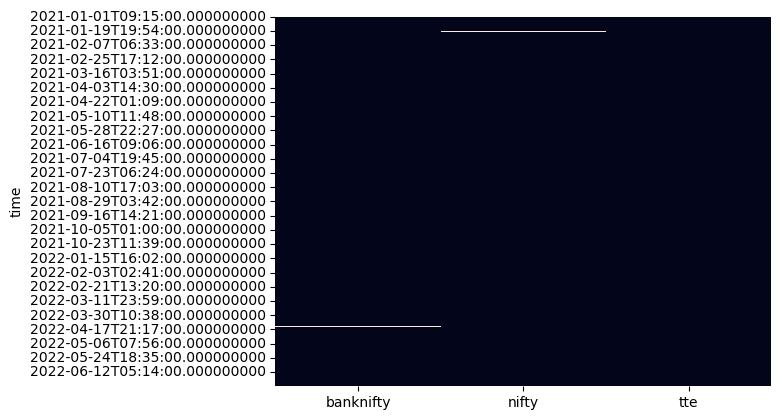

In [9]:
sns.heatmap(df.isnull(),cbar=False)

In [10]:
df['banknifty'].bfill(axis='rows',inplace=True)

<AxesSubplot:ylabel='time'>

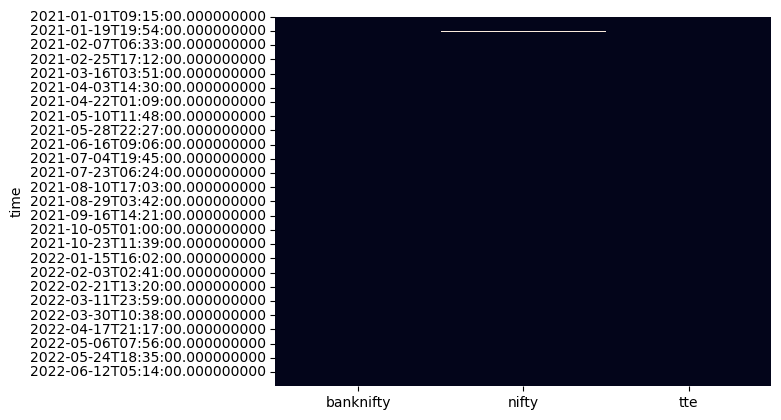

In [11]:
sns.heatmap(df.isnull(),cbar=False)

In [12]:
df['nifty'].bfill(axis='rows',inplace=True)

<AxesSubplot:ylabel='time'>

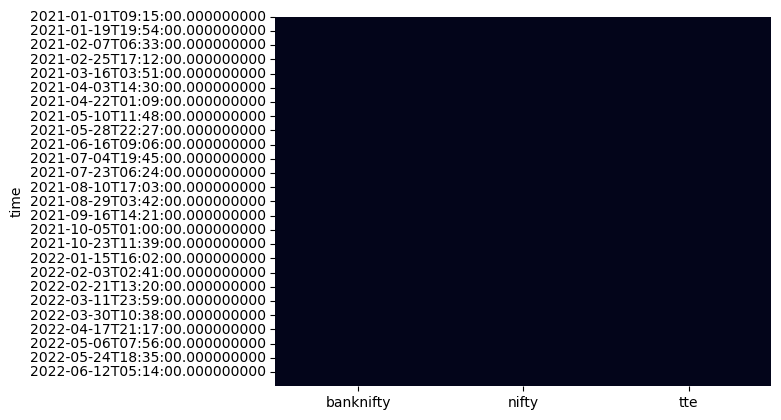

In [13]:
sns.heatmap(df.isnull(),cbar=False)

In [14]:
df['Spread'] = df['banknifty'] - df['nifty']

In [15]:
df.head()

,banknifty,nifty,tte,Spread
time,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588


                     banknifty     nifty  tte    Spread   Z_Score  Signal  \
time                                                                        
2021-01-01 10:31:00   0.267424  0.190082   27  0.077342 -0.254609       0   
2021-01-01 10:32:00   0.268235  0.190296   27  0.077938 -0.032961       0   
2021-01-01 10:33:00   0.267530  0.190578   27  0.076953 -0.695087       0   
2021-01-01 10:34:00   0.266578  0.189142   27  0.077435 -0.588093       0   
2021-01-01 10:35:00   0.266659  0.190714   27  0.075946 -1.709383       1   
...                        ...       ...  ...       ...       ...     ...   
2022-06-30 15:26:00   0.240701  0.214758   28  0.025943  0.236177       0   
2022-06-30 15:27:00   0.240875  0.216558   28  0.024317 -1.252451       1   
2022-06-30 15:28:00   0.242115  0.216794   28  0.025321 -0.193173       0   
2022-06-30 15:29:00   0.243426  0.216455   28  0.026971  1.501264      -1   
2022-06-30 15:30:00   0.241907  0.216081   28  0.025827  0.409790       0   

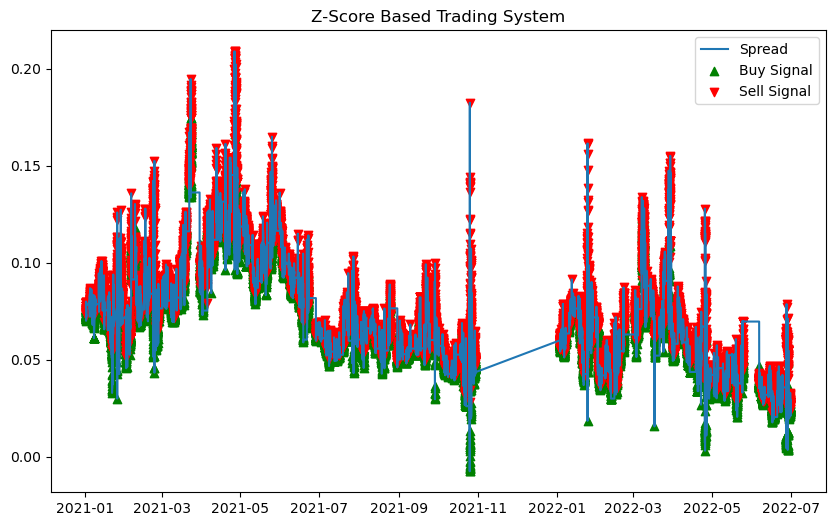

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming you have a DataFrame named 'df' with columns 'Spread', 'tte', etc.
# Replace this with your actual DataFrame and column names

# Calculate z-score
rolling_mean = df['Spread'].rolling(window=20).mean()
rolling_std = df['Spread'].rolling(window=20).std()
df['Z_Score'] = (df['Spread'] - rolling_mean) / rolling_std

# Define z-score thresholds for trading signals
upper_threshold = 1.0
lower_threshold = -1.0

# Generate trading signals
df['Signal'] = 0
df.loc[df['Z_Score'] > upper_threshold, 'Signal'] = -1  # Sell signal
df.loc[df['Z_Score'] < lower_threshold, 'Signal'] = 1   # Buy signal

# Apply trading signals to calculate P/L
df['Position'] = df['Signal'].shift(1)
df['P/L'] = df['Position'] * (df['Spread'] * (df['tte'] ** 0.7))

# Classification Report
df['Z_Score_Binned'] = pd.cut(df['Z_Score'], bins=[-float('inf'), lower_threshold, upper_threshold, float('inf')],
                               labels=[-1, 0, 1], include_lowest=True)
df['Signal_Binned'] = pd.cut(df['Signal'], bins=[-float('inf'), -0.5, 0.5, float('inf')],
                             labels=[-1, 0, 1], include_lowest=True)
df.dropna(inplace=True)



# Print the DataFrame with the new 'P/L' column
print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['Spread'], label='Spread')
plt.scatter(df.loc[df['Signal'] == 1].index, df['Spread'][df['Signal'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(df.loc[df['Signal'] == -1].index, df['Spread'][df['Signal'] == -1], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title('Z-Score Based Trading System')
plt.show()


In [26]:
Z_Score_classification_report_result = classification_report(df['Z_Score_Binned'], df['Signal_Binned'])

# Print the classification report
print("Z_score Classification Report:")
print(Z_Score_classification_report_result)

Z_score Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     26598
           0       1.00      1.00      1.00    610810
           1       0.00      0.00      0.00     24580

    accuracy                           0.92    661988
   macro avg       0.33      0.33      0.33    661988
weighted avg       0.92      0.92      0.92    661988



In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(12, 8))

                       Spread  Z_Score_Signal  RF_Signal    RF_P/L
time                                                              
2022-03-31 03:25:00  0.064101               0          0       NaN
2022-03-31 03:26:00  0.064101               0          0  0.000000
2022-03-31 03:27:00  0.064101               0          0  0.000000
2022-03-31 03:28:00  0.064101               0          0  0.000000
2022-03-31 03:29:00  0.064101               0          0  0.000000
...                       ...             ...        ...       ...
2022-06-30 15:26:00  0.025943               0          0  0.000000
2022-06-30 15:27:00  0.024317               1          0  0.000000
2022-06-30 15:28:00  0.025321               0          0  0.000000
2022-06-30 15:29:00  0.026971              -1         -1  0.000000
2022-06-30 15:30:00  0.025827               0          0 -0.266124

[131766 rows x 4 columns]


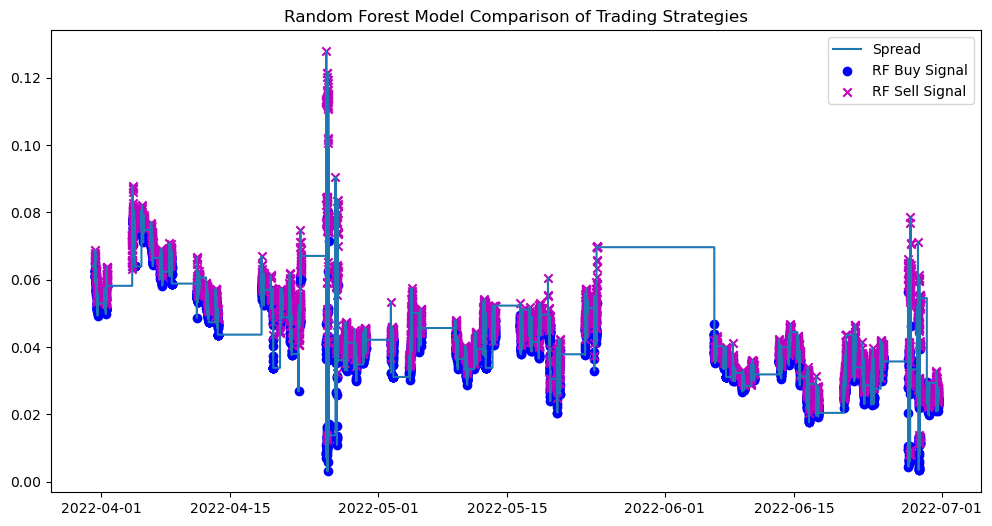

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming you have a DataFrame named 'df' with columns 'Spread', 'tte', etc.
# Replace this with your actual DataFrame and column names

# Define z-score thresholds for trading signals
upper_threshold = 1.0
lower_threshold = -1.0

# Generate trading signals for z-score model
df['Z_Score_Signal'] = 0
df.loc[df['Z_Score'] > upper_threshold, 'Z_Score_Signal'] = -1  # Sell signal
df.loc[df['Z_Score'] < lower_threshold, 'Z_Score_Signal'] = 1   # Buy signal

# Features for machine learning model
df['Spread_Pct_Change'] = df['Spread'].pct_change()
df['Z_Score_Lagged'] = df['Z_Score'].shift(1)

# Drop rows with NaN or infinite values
df.dropna(inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Features for machine learning model
features = ['Z_Score_Lagged', 'Spread_Pct_Change']

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Train machine learning model (Random Forest)
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(train[features], train['Z_Score_Signal'])

# Make predictions on the test set
test['RF_Signal'] = model1.predict(test[features])

# Apply trading signals to calculate P/L for the machine learning model
test['ML_Position'] = test['RF_Signal'].shift(1)
test['RF_P/L'] = test['ML_Position'] * (test['Spread'] * (test['tte'] ** 0.7))


# Print the DataFrame with new columns
print(test[['Spread', 'Z_Score_Signal', 'RF_Signal', 'RF_P/L']])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test['Spread'], label='Spread')
plt.scatter(test.loc[test['RF_Signal'] == 1].index, test['Spread'][test['RF_Signal'] == 1], marker='o', color='b', label='RF Buy Signal')
plt.scatter(test.loc[test['RF_Signal'] == -1].index, test['Spread'][test['RF_Signal'] == -1], marker='x', color='m', label='RF Sell Signal')
plt.legend()
plt.title('Random Forest Model Comparison of Trading Strategies')
plt.show()


In [33]:
actual_labels1 = test['Z_Score_Signal']
predicted_labels1 = test['RF_Signal']

# Generate classification report
Random_Forest_classification_report_result= classification_report(actual_labels1, predicted_labels1)

# Print the classification report
print("Random Forest Classification Report:")
print(Random_Forest_classification_report_result)


Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.78      0.83      0.81      4256
           0       0.99      0.98      0.99    123126
           1       0.78      0.83      0.80      4384

    accuracy                           0.97    131766
   macro avg       0.85      0.88      0.86    131766
weighted avg       0.97      0.97      0.97    131766



In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier 

                       Spread  Z_Score_Signal  XGB_Signal   XGB_P/L
time                                                               
2022-03-31 03:27:00  0.064101               1           1       NaN
2022-03-31 03:28:00  0.064101               1           1  0.676929
2022-03-31 03:29:00  0.064101               1           1  0.676929
2022-03-31 03:30:00  0.064101               1           1  0.676929
2022-03-31 03:31:00  0.064101               1           1  0.676929
...                       ...             ...         ...       ...
2022-06-30 15:26:00  0.025943               1           1  0.267320
2022-06-30 15:27:00  0.024317               2           2  0.250560
2022-06-30 15:28:00  0.025321               1           1  0.521821
2022-06-30 15:29:00  0.026971               0           0  0.277912
2022-06-30 15:30:00  0.025827               1           1  0.000000

[131764 rows x 4 columns]


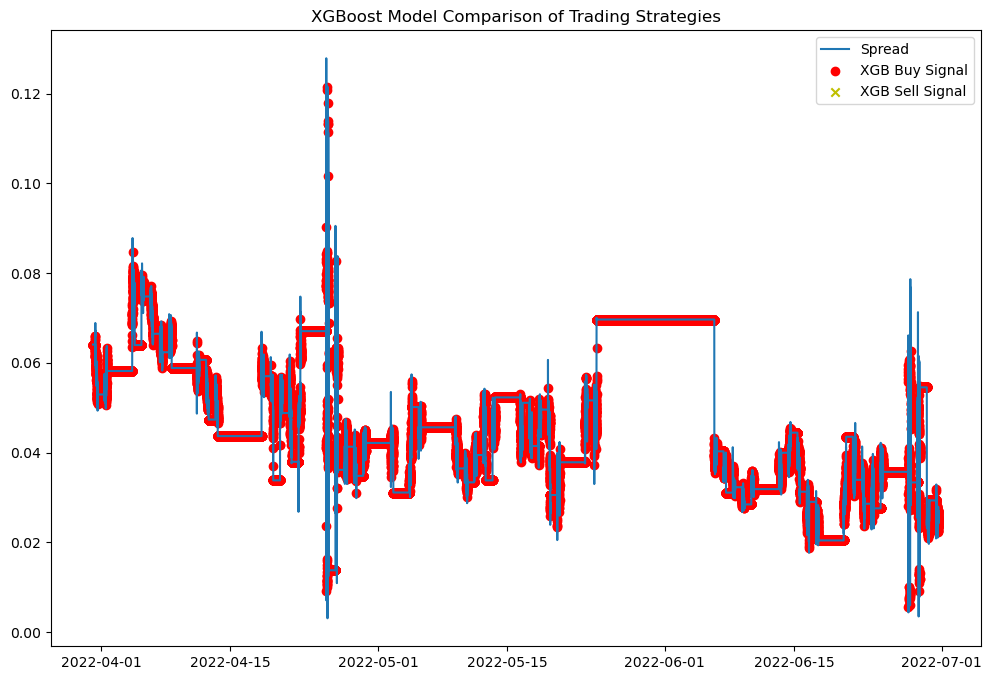

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Assuming you have a DataFrame named 'df' with columns 'Spread', 'tte', etc.
# Replace this with your actual DataFrame and column names

# Define z-score thresholds for trading signals
upper_threshold = 1.0
lower_threshold = -1.0

# Generate trading signals for z-score model
df['Z_Score_Signal'] = 0
df.loc[df['Z_Score'] > upper_threshold, 'Z_Score_Signal'] = -1  # Sell signal
df.loc[df['Z_Score'] < lower_threshold, 'Z_Score_Signal'] = 1   # Buy signal

# Features for machine learning model
df['Spread_Pct_Change'] = df['Spread'].pct_change()
df['Z_Score_Lagged'] = df['Z_Score'].shift(1)

# Drop rows with NaN or infinite values
df.dropna(inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Map classes to start from 0
class_mapping = {-1: 0, 0: 1, 1: 2}
df['Z_Score_Signal'] = df['Z_Score_Signal'].map(class_mapping)

# Features for machine learning model
features = ['Z_Score_Lagged', 'Spread_Pct_Change']

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Train machine learning model (XGBoost)
model2 = XGBClassifier(n_estimators=100, random_state=42)
model2.fit(train[features], train['Z_Score_Signal'])

# Make predictions on the test set
test['XGB_Signal'] = model2.predict(test[features])

# Apply trading signals to calculate P/L for the XGBoost model
test['XGB_Position'] = test['XGB_Signal'].shift(1)
test['XGB_P/L'] = test['XGB_Position'] * (test['Spread'] * (test['tte'] ** 0.7))


# Print the DataFrame with new columns
print(test[['Spread', 'Z_Score_Signal', 'XGB_Signal', 'XGB_P/L']])

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(test['Spread'], label='Spread')
plt.scatter(test.loc[test['XGB_Signal'] == 1].index, test['Spread'][test['XGB_Signal'] == 1], marker='o', color='r', label='XGB Buy Signal')
plt.scatter(test.loc[test['XGB_Signal'] == -1].index, test['Spread'][test['XGB_Signal'] == -1], marker='x', color='y', label='XGB Sell Signal')
plt.legend()
plt.title('XGBoost Model Comparison of Trading Strategies')
plt.show()


In [49]:
# Classification Report
classification_report_xgb = classification_report(test['Z_Score_Signal'], test['XGB_Signal'])
print("XGBoost Classification Report:")
print(classification_report_xgb)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      4256
           1       0.99      0.99      0.99    123125
           2       0.81      0.84      0.82      4384

    accuracy                           0.98    131765
   macro avg       0.87      0.89      0.88    131765
weighted avg       0.98      0.98      0.98    131765



In [41]:
# Print the classification report
print("Z_score Classification Report:")
print(Z_Score_classification_report_result)

Z_score Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     26598
           0       1.00      1.00      1.00    610810
           1       0.00      0.00      0.00     24580

    accuracy                           0.92    661988
   macro avg       0.33      0.33      0.33    661988
weighted avg       0.92      0.92      0.92    661988



In [42]:
# Print the classification report
print("Random Forest Classification Report:")
print(Random_Forest_classification_report_result)


Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.78      0.83      0.81      4256
           0       0.99      0.98      0.99    123126
           1       0.78      0.83      0.80      4384

    accuracy                           0.97    131766
   macro avg       0.85      0.88      0.86    131766
weighted avg       0.97      0.97      0.97    131766



In [51]:
df.head()

,banknifty,nifty,tte,Spread,Z_Score,Signal,Position,P/L,Z_Score_Binned,Signal_Binned,Z_Score_Signal,Spread_Pct_Change,Z_Score_Lagged
time,,,,,,,,,,,,,
2021-01-01 10:40:00,0.267386,0.190999,27,0.076388,-0.850946,0,1.0,0.767326,0,0,1,0.003402,-1.096900
2021-01-01 10:41:00,0.267676,0.190981,27,0.076695,-0.585100,0,0.0,0.000000,0,0,1,0.004026,-0.850946
2021-01-01 10:42:00,0.266852,0.190817,27,0.076035,-0.928878,0,0.0,0.000000,0,0,1,-0.008612,-0.585100
2021-01-01 10:43:00,0.267171,0.190740,27,0.076431,-0.594937,0,0.0,0.000000,0,0,1,0.005208,-0.928878
2021-01-01 10:44:00,0.267031,0.190513,27,0.076518,-0.482396,0,0.0,0.000000,0,0,1,0.001132,-0.594937
